# import package

In [782]:
import time
import math
import random
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
plt.rcParams['font.family'] = 'Noto Sans CJK TC'
plt.rcParams['axes.unicode_minus'] = False

random.seed(6015)
np.random.seed(6015)

In [783]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Preprocess and setting

## Dayoff 檔案處理
將 txt 檔改成 {worker : dayoff} 與 {dayoff : worker} 的兩個字典

In [784]:
dayoff_file = open("dayoff.txt", "r")
dayoff = dayoff_file.read()
dayoff_dict_worker = {}
for i, text in enumerate(dayoff.split('\n')[1:]):
    dayoff_dict_worker[i] = [int(t)-1 for t in text.split('\t')[-1].split(',')]
dayoff_dict_worker
# worker : dayoff

{0: [4, 5, 23],
 1: [7],
 2: [12, 13],
 3: [7],
 4: [17, 18],
 5: [23, 24],
 6: [22, 24],
 7: [10],
 8: [21, 22],
 9: [13, 19],
 10: [8, 9],
 11: [14],
 12: [17, 18],
 13: [8, 9],
 14: [2]}

In [785]:
dayoff_file = open("dayoff.txt", "r")
dayoff = dayoff_file.read()
total_day = []
for text in dayoff.split('\n')[1:]:
    total_day.extend([int(t)-1 for t in text.split('\t')[-1].split(',')])
total_day = list(set(total_day))

dayoff_dict = {}
for d in total_day:
    if d not in dayoff_dict.keys():
        dayoff_dict[d] = []
    for i, text in enumerate(dayoff.split('\n')[1:]):
        if d in [int(t)-1 for t in text.split('\t')[-1].split(',')]:
            dayoff_dict[d].append(i)
        
dayoff_dict  
# dayoff : worker

{2: [14],
 4: [0],
 5: [0],
 7: [1, 3],
 8: [10, 13],
 9: [10, 13],
 10: [7],
 12: [2],
 13: [2, 9],
 14: [11],
 17: [4, 12],
 18: [4, 12],
 19: [9],
 21: [8],
 22: [6, 8],
 23: [0, 5],
 24: [5, 6]}

## constraint

In [786]:
def constraint(input_X):
    for j in range(input_X.shape[1]):
        # Every day shift needs at least 9 workers. ∑ I(X_ij=d) >= 9
        if sum(input_X[:, j] == "d") < 9:
            print("d", j)
            return False
        
        # Every night shift needs exactly 2 workers. ∑ I(X_ij=n) = 2
        if sum(input_X[:, j] == "n") != 2:
            print("n", j)
            return False
        
        # Every late-night shfit needs exactly 2 workers. ∑ I(X_ij=l) = 2
        if sum(input_X[:, j] == "l") != 2:
            print("l", j)
            return False
    
    return True

## Initial Sequence

In [787]:
def generate_x():
    pass_constraint = False
    while not pass_constraint:
        input_X = []
        for i in range(days):
            schedule = ["n", "n", "l", "l"]
            dayoff_num = 11
            if i in dayoff_dict.keys():
                dayoff_num = 11-len(dayoff_dict[i])
                
            schedule += ['d'] * dayoff_num
            random.shuffle(schedule)
            
            if i in dayoff_dict.keys():
                for index in dayoff_dict[i]:
                    schedule.insert(index, 'h')
                    
            input_X.append(schedule)
            
        input_X = np.array(input_X).transpose()
        pass_constraint = constraint(input_X)
    return input_X

In [788]:
input_X = generate_x()
print(input_X.shape)

(15, 30)


## Objective Function
Set the objective function output to be absolute value, and make the problem as minimization.

In [841]:
def objective_fp(work):
    string = "".join(work).replace("d", "h")
    split = string.split("h")

    f_p = 0
    for section in split.copy():
        if section == "llnn":
            f_p -= 0
            split.remove("llnn")
        elif section == "lln":
            f_p -= 40
            split.remove("lln")
        elif section == "lnn":
            f_p -= 40
            split.remove("lnn")
        elif section == "ln":
            f_p -= 60
            split.remove("ln")
        elif len(section) > 1:
            f_p -= 120
    return f_p


def objective_fc(work):
    string = "".join(work).replace("d", "h")
    split = string.split("h")    
    f_c = 0
    for section in split.copy():
        f_c -= 100 * max(len(section)-4, 0)
    return f_c


def objective_fd(work):
    string = "".join(work).replace("n", "l")
    split = string.split("l")
    
    f_d = 0
    for section in split.copy():
        f_d -= (len(section)-11)**2
        
    return f_d


def objective_f(input_X):
    f_p, f_c, f_d = 0, 0, 0
    for i in range(input_X.shape[0]):
        work = list(input_X[i, :])
        f_p += objective_fp(work)
        f_c += objective_fc(work)
        f_d += objective_fd(work)
    return abs(f_p + f_c + f_d)/15

## Mutation Example
To make it pass the constraint easier, we do the mutation on one (or more) day(s), and exchange work schedules except dayoffs.

In [842]:
# num_point should be 1< num_point < 13
def mutation(input_X, num_point=2):
    pass_constraint = False
    while not pass_constraint:
        new_X = []
        for j in range(input_X.shape[1]):
            print(j)
            day_shift = list(input_X[:, j])
            day_shift_copy = list(input_X[:, j]).copy()
            candidate = list(range(input_X.shape[0]))
            if j in dayoff_dict.keys():
                for worker in dayoff_dict[j]:
                    candidate.remove(worker)

            index = list(np.random.choice(candidate, 2))
            index.append(index[0])
            print(index)

            for p in range(len(index)-1):
                day_shift_copy[index[p]] = day_shift[index[p+1]]
            new_X.append(day_shift_copy)
        new_X = np.array(new_X).transpose()
    return new_X

## encoding_X
not important

In [843]:
# Encoding "h", "d", "n", "l" as 0, 1, 2, 3
def encoding_X(input_X):
    X = input_X.copy()
    X[input_X == 'h'] = 0
    X[input_X == 'd'] = 1
    X[input_X == 'n'] = 2
    X[input_X == 'l'] = 3
    return X.astype(int)

def decoding_X(input_X):
    X = np.zeros(input_X.shape, dtype=str)
    X[input_X == 0] = 'h'
    X[input_X == 1] = 'd'
    X[input_X == 2] = 'n'
    X[input_X == 3] = 'l'
    return X

# 2. 
Use the self-adaptive hill climbing and random walk (two simplest evolutionary strategies) under 1/5th-rule to do the simple trial (10000 iterations).

In [910]:
def mutation_ES(input_X, sigma):
    pass_constraint = False
    while not pass_constraint:
        new_X = input_X.copy()
        chosen_day = np.random.choice(input_X.shape[1], sigma, replace=False)
        for j in chosen_day:
            day_shift = list(input_X[:, j])
            day_shift_copy = list(input_X[:, j]).copy()
            candidate = list(range(input_X.shape[0]))
            
            if j in dayoff_dict.keys(): 
                for worker in dayoff_dict[j]:
                    candidate.remove(worker) # 從可變動的班次清單中，移除放假日

            index = list(np.random.choice(candidate, 2, replace=False))
            index.append(index[0])

            for p in range(len(index)-1):
                day_shift_copy[index[p]] = day_shift[index[p+1]]
                
            new_X[:, j] = day_shift_copy
        pass_constraint = constraint(new_X)
    return new_X


def self_adaptive_ES(do_Random_Walk=True):
    sigma, a = 5, 1
    s, L = 1, 100
    iteration = 10000
    
    # initial x
    p_x = generate_x()
    best_x, best_y = p_x, objective_f(p_x)
    total_y = [best_y]
    t = 0 
    while t < iteration: 
        p_new_x = mutation_ES(p_x, sigma)
        p_new_y = objective_f(p_new_x)

        if p_new_y < best_y:
            best_x, best_y = p_new_x, p_new_y
            p_x = p_new_x
            s += 1
            
        # Random Walk 與 Hill climbing 的差異在於會不會每次都保留子代
        if do_Random_Walk:  
            p_x = p_new_x
        
        if t % L == 0:
            p_s = s / L
            if p_s < 0.2:
                if sigma < 29:
                    sigma = sigma + a  # 當成功率小 → 增加變異強度
            elif p_s > 0.2:
                if sigma > 1:
                    sigma = sigma - a  # 當成功率大 → 縮小變異強度
            s = 0

        t += 1
        total_y.append(best_y)
    return best_x, best_y, total_y

## Hill Climbing

In [911]:
best_x_HC, best_y_HC, total_HC = self_adaptive_ES(do_Random_Walk=False)

In [912]:
best_y_HC

687.2666666666667

In [913]:
pd.DataFrame(best_x_HC)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,n,d,d,d,h,h,d,n,d,n,d,d,n,d,d,d,d,n,d,d,d,n,d,h,d,d,d,d,l,d
1,d,d,l,d,l,d,n,h,l,d,d,d,l,d,d,d,d,n,d,d,l,d,d,d,d,d,d,l,d,l
2,d,l,d,n,d,d,d,l,d,d,d,d,h,h,d,n,d,l,d,l,d,n,d,d,d,d,n,d,d,d
3,d,d,n,d,d,d,n,h,d,d,d,d,d,d,n,d,n,d,d,l,n,d,n,d,d,n,d,d,l,d
4,n,d,d,d,l,d,d,d,d,l,d,d,l,d,d,d,n,h,h,d,d,d,d,l,d,d,d,d,d,d
5,d,n,d,d,n,d,d,d,l,d,l,d,d,d,l,d,d,l,d,d,d,l,d,h,h,d,d,n,d,d
6,d,d,n,d,n,d,d,d,d,n,d,d,d,l,d,d,d,d,l,d,d,d,h,l,h,n,d,d,n,d
7,d,n,d,n,d,d,d,l,d,d,h,l,d,n,d,d,d,d,n,d,d,d,l,d,n,d,l,d,d,l
8,d,d,l,d,d,d,l,d,n,d,l,d,d,l,d,d,l,d,n,d,d,h,h,d,l,d,d,d,d,d
9,l,d,d,d,d,l,d,d,n,d,d,d,n,h,d,l,d,d,d,h,d,l,d,d,d,l,d,d,d,n


## Random Walk

In [914]:
best_x_RW, best_y_RW, total_RW = self_adaptive_ES(do_Random_Walk=True)

In [915]:
best_y_RW

793.2666666666667

In [916]:
pd.DataFrame(best_x_RW)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,d,l,d,d,h,h,n,d,d,d,l,d,d,d,d,d,d,d,d,d,l,d,d,h,d,d,n,d,d,d
1,d,d,d,d,d,d,d,h,d,d,d,l,d,n,d,d,l,d,l,n,n,d,d,l,d,d,d,n,d,d
2,l,d,l,d,n,d,d,l,d,d,d,l,h,h,d,n,d,d,l,l,d,d,n,d,l,d,d,d,d,d
3,n,d,n,d,d,d,l,h,d,d,d,d,d,d,d,l,n,n,d,d,d,d,l,d,n,d,d,n,d,d
4,d,d,d,d,l,d,d,n,d,l,d,d,d,n,d,d,d,h,h,d,d,n,d,d,d,d,n,d,d,l
5,n,d,d,l,n,d,d,d,n,d,d,d,d,d,d,l,l,d,d,d,d,d,n,h,h,d,d,d,d,d
6,d,d,l,d,d,d,d,d,d,d,d,d,d,d,d,d,n,d,n,d,d,d,h,d,h,d,d,d,n,d
7,d,l,d,d,d,l,d,d,d,n,h,d,n,d,d,n,d,l,n,d,d,d,l,d,d,d,d,d,d,n
8,d,d,d,d,d,d,d,d,l,l,n,d,l,l,n,d,d,d,d,l,d,h,h,l,n,d,l,d,d,d
9,d,d,d,n,d,n,d,d,d,n,d,n,d,h,l,d,d,n,d,h,d,n,d,d,d,n,d,d,n,d


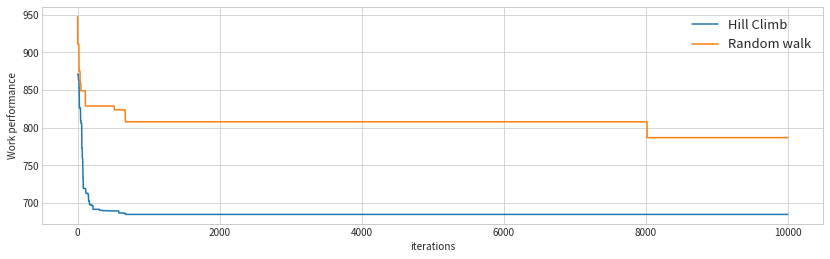

In [849]:
plt.figure(figsize=(14, 4))
plt.plot([i + 1 for i in range(len(total_HC))], total_HC, label='Hill Climb')
plt.plot([i + 1 for i in range(len(total_RW))], total_RW, label='Random walk')

plt.xlabel("iterations")
plt.ylabel("Work performance")
plt.legend(fontsize=13)

# 3.
pick 4 methods to optimize the work schedule. Specify in details about the parameters of the selected methods.

## Simulated Annealing

In [870]:
def mutation_SA(input_X, num_point=2):
    pass_constraint = False
    while not pass_constraint:
        new_X = input_X.copy()
        chosen_day = np.random.choice(input_X.shape[1], 5, replace=False)
        for j in chosen_day:
        #for j in range(input_X.shape[1]):
            day_shift = list(input_X[:, j])
            day_shift_copy = list(input_X[:, j]).copy()
            candidate = list(range(input_X.shape[0]))
            if j in dayoff_dict.keys():
                for worker in dayoff_dict[j]:
                    candidate.remove(worker)

            index = list(np.random.choice(candidate, num_point, replace=False))
            index.append(index[0])

            for p in range(len(index)-1):
                day_shift_copy[index[p]] = day_shift[index[p+1]]
            new_X[:, j] = day_shift_copy
        pass_constraint = constraint(new_X)
    return new_X


def SA_main_program():
    iteration = 100
    total_SA = []
    T_0 = 100
    final_T = 1e-10
    ind = generate_x()
    d = objective_f(ind)
    best_x, best_y = ind, d
    t = 0
    while (t < iteration) and (T_0 > final_T):
        new_ind = mutation_SA(ind)
        new_y = objective_f(new_ind)
        dE = new_y - d
        if dE <= 0: # 直接接受新解
            ind, d = new_ind, new_y
            if new_y < best_y:  # 更新最佳解
                best_x, best_y = new_ind, new_y
        else:
            if np.random.random_sample() < np.exp(-dE/T_0):
                ind, d = new_ind, new_y
        T_0 = 0.98*T_0 #降溫
        t += 1
        total_SA.append(best_y)
    return best_x, best_y, total_SA


def SA_main_program_particle(particle_num=100):
    seq_list = [generate_x() for _ in range(particle_num)] # 100 particle
    iteration = 100
    total_SA = []
    best_x, best_y = None, 3000
    for ind in seq_list:
        T_0 = 100
        final_T = 1e-10
        d = objective_f(ind)
        t = 0
        while (t < iteration) and (T_0 > final_T):
            new_ind = mutation_SA(ind)
            new_y = objective_f(new_ind)
            dE = new_y - d
            if dE <= 0: # 直接接受新解
                ind, d = new_ind, new_y
                if new_y < best_y:  # 更新最佳解
                    best_x, best_y = new_ind, new_y
            else:
                if np.random.random_sample() < np.exp(-dE/T_0):
                    ind, d = new_ind, new_y
            T_0 = 0.98*T_0 #降溫
            t += 1
        total_SA.append(best_y)
    return best_x, best_y, total_SA

In [871]:
best_x_SA, best_y_SA, total_SA = SA_main_program_particle()

In [872]:
pd.DataFrame(best_x_SA)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,d,l,d,d,h,h,d,l,d,n,d,d,d,d,l,d,l,d,d,n,d,d,l,h,d,d,l,d,d,l
1,d,d,d,d,d,l,d,h,d,d,d,d,d,d,d,d,d,d,d,d,n,d,l,d,d,d,d,d,d,d
2,d,d,l,l,l,d,d,d,d,l,d,d,h,h,l,d,d,d,d,d,d,l,d,d,d,n,d,d,d,d
3,d,d,d,d,n,d,d,h,n,d,d,d,d,d,n,d,l,d,d,d,d,d,d,l,d,d,d,n,d,d
4,n,d,l,d,d,l,d,d,l,d,d,l,d,d,n,d,d,h,h,l,d,n,d,d,l,d,d,d,l,n
5,d,l,d,n,d,d,d,d,n,n,l,d,d,l,d,n,d,d,l,d,d,d,d,h,h,l,d,d,l,d
6,l,d,n,n,n,d,d,d,d,d,d,d,l,d,d,l,d,d,n,d,n,d,h,d,h,d,d,l,d,d
7,d,n,d,d,d,d,d,d,d,d,h,d,d,n,d,d,n,d,d,l,d,d,d,l,d,d,n,l,d,d
8,d,d,d,d,d,n,d,d,d,d,l,n,d,l,d,l,d,l,d,d,l,h,h,d,n,d,n,d,n,d
9,d,d,d,d,l,d,l,d,d,d,d,n,d,h,d,d,d,n,d,h,l,d,d,d,d,d,d,d,d,d


In [873]:
best_y_SA

790.8666666666667

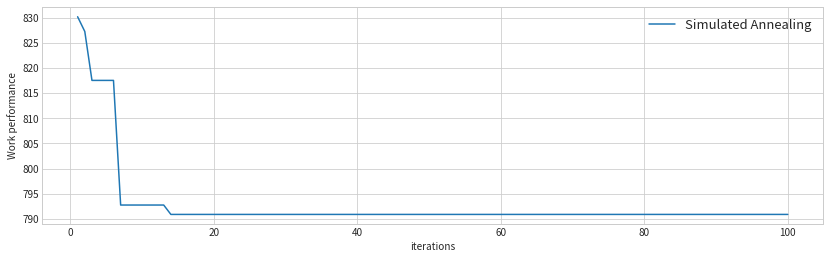

In [874]:
plt.figure(figsize=(14, 4))
plt.plot([i + 1 for i in range(len(total_SA))], total_SA, label='Simulated Annealing')

plt.xlabel("iterations")
plt.ylabel("Work performance")
plt.legend(fontsize=13)

## Tabu Search

In [875]:
from itertools import combinations

comb = []
workers, days = 15, 30
for j in range(days):
    candidate = list(range(workers))
    if j in dayoff_dict.keys():
        for w in dayoff_dict[j]:
            candidate.remove(w)
            
        for (w1, w2) in combinations(candidate, 2):
                comb.append( (j, w1, w2) )
len(comb)

1430

In [876]:
def mutation_TS(input_X, solver):
    pass_constraint = False
    while not pass_constraint:
        j, w1, w2 = solver
        input_X[w1, j], input_X[w2, j] = input_X[w2, j], input_X[w1, j]
        pass_constraint = constraint(input_X)
    return input_X


def TS_main_program():
    p_x = generate_x()
    p_y = objective_f(p_x)
    best_x, best_y = p_x, p_y
    total_TS = [best_y]
    list_length = 20
    tabu_list = [0]*list_length

    t, H = 0, 0
    while t < 100:
        current_solver = comb[np.random.choice(len(comb))]
        if current_solver not in tabu_list:
            # 選取目前的解放入 tabu_list
            tabu_list[H] = current_solver
            H += 1 
            # 交換
            p_x = mutation_TS(p_x, current_solver)
            p_y = objective_f(p_x)

            # 更新最佳解
            if p_y < best_y:
                best_x = p_x
                best_y = p_y

        if H >= list_length:  # reset H
            H = 0
        t += 1
        total_TS.append(best_y)
    return best_x, best_y, total_TS


def TS_main_program_particle(particle_num=100):
    seq_list = [generate_x() for _ in range(particle_num)] # 100 particle
    iteration = 100
    total_TS = []
    best_x, best_y = None, 3000
    
    for p_x in seq_list:
        p_y = objective_f(p_x)
        #best_x, best_y = p_x, p_y
        list_length = 20
        tabu_list = [0]*list_length
        t, H = 0, 0
        while t < iteration:
            current_solver = comb[np.random.choice(len(comb))]
            if current_solver not in tabu_list:
                # 選取目前的解放入 tabu_list
                tabu_list[H] = current_solver
                H += 1 
                # 交換
                p_x = mutation_TS(p_x, current_solver)
                p_y = objective_f(p_x)

                # 更新最佳解
                if p_y < best_y:
                    best_x, best_y = p_x, p_y

            if H >= list_length:  # reset H
                H = 0
            t += 1
        total_TS.append(best_y)  # 只存每個 particle 跑出的 best
            
    return best_x, best_y, total_TS

In [877]:
#best_x_TS, best_y_TS, total_TS = TA_main_program()
best_x_TS, best_y_TS, total_TS = TS_main_program_particle()

In [878]:
pd.DataFrame(best_x_TS)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,d,d,d,d,h,h,d,d,d,d,d,n,d,d,n,d,d,d,d,d,d,l,d,h,n,d,d,d,d,n
1,d,l,d,l,d,d,d,h,d,n,d,l,d,l,l,d,d,d,d,d,d,d,d,n,l,d,d,d,d,d
2,d,d,d,d,l,l,d,n,n,d,d,d,h,h,d,d,l,d,d,d,l,d,d,d,l,d,n,d,d,d
3,d,d,d,d,n,d,d,h,d,d,d,d,d,n,d,d,d,l,d,d,n,d,n,d,d,d,d,d,n,l
4,d,d,n,d,n,d,d,d,l,d,d,d,d,d,l,l,l,h,h,n,n,d,d,d,d,d,d,d,n,d
5,d,n,l,d,d,d,l,l,n,d,d,d,n,d,n,d,n,d,d,d,d,n,n,h,h,l,d,n,d,d
6,l,d,d,d,d,d,d,d,d,l,n,d,d,d,d,l,d,n,d,l,d,d,h,l,h,l,l,n,d,d
7,l,d,d,d,d,n,d,n,l,d,h,n,d,n,d,d,d,d,n,d,d,n,d,d,d,n,d,d,d,n
8,n,d,l,d,l,d,d,d,d,d,d,d,n,d,d,d,d,n,d,l,d,h,h,d,d,d,d,d,l,d
9,d,d,d,d,d,d,d,d,d,l,n,d,d,h,d,d,d,d,l,h,l,d,l,d,d,d,d,l,d,d


In [879]:
best_y_TS

805.5333333333333

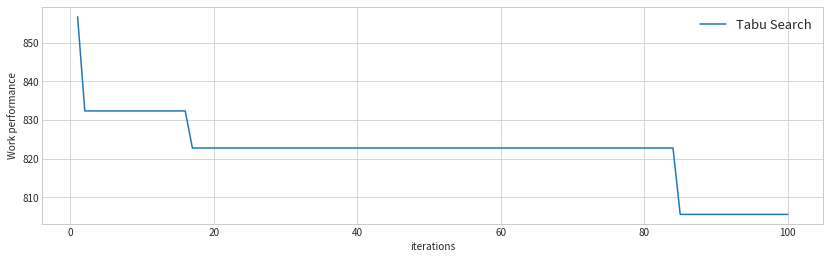

In [880]:
plt.figure(figsize=(14, 4))
plt.plot([i + 1 for i in range(len(total_TS))], total_TS, label='Tabu Search')

plt.xlabel("iterations")
plt.ylabel("Work performance")
plt.legend(fontsize=13)

## Ant Colony Optimization

In [881]:
from itertools import combinations

comb = []
workers, days = 15, 30
for j in range(days):
    candidate = list(range(workers))
    if j in dayoff_dict.keys():
        for w in dayoff_dict[j]:
            candidate.remove(w)
            
        for (w1, w2) in combinations(candidate, 2):
                comb.append( (j, w1, w2) )
len(comb)

1430

In [882]:
def mutation_ACO(input_X, solver):
    pass_constraint = False
    while not pass_constraint:
        j, w1, w2 = solver
        input_X[w1, j], input_X[w2, j] = input_X[w2, j], input_X[w1, j]
        pass_constraint = constraint(input_X)
    return input_X


def roulette_wheel_selection(fitness_ls):
    f_sum = sum(fitness_ls)
    probability = [f/f_sum for f in fitness_ls]
    p = np.random.random_sample()
    sum_prob = 0
    for i, prob in enumerate(probability):
        sum_prob += prob
        if sum_prob >= p:
            return i

In [883]:
def ACO_main_program():
    n_iterations = 100
    best_x, best_y = None, 3000
    total_ACO = []
    pop_size = 100  # 蟻群數量
    evaporate_rate = 0.1  # 費洛蒙蒸發速度
    alpha, beta = 1, 1   
    pheromone_map = np.ones(len(comb))
    n_best = 5

    i = 0
    while i < n_iterations:
        objective_all = [0]*pop_size
        base_solution = generate_x() # initialize
        for n in range(pop_size):
            fitness_ls = []
            for ls_loc, candidate in enumerate(comb):
                pheromone = pheromone_map[ls_loc]
                fitness = (pheromone**alpha)
                fitness_ls.append(fitness)

            index = roulette_wheel_selection(fitness_ls)
            p_x = mutation_ACO(base_solution, comb[index])

            # 計算目前的 fitness
            p_y = objective_f(p_x)
            objective_all[n] = (p_x, p_y, index)

        # 排序所有螞蟻走出的距離小 → 大
        objective_all = sorted(objective_all, key=lambda x: x[1])

        # 費洛蒙隨時間蒸散
        pheromone_map *= (1 - evaporate_rate)

        # 給前 {n_best} 短的路徑組合加上費洛蒙
        for n in range(n_best):
            solution = objective_all[n][2]
            pheromone_map[solution] += 100/objective_all[n][1]

        # 更新最佳解
        if objective_all[0][1] < best_y:
            (best_x, best_y, _) = objective_all[0]

        total_ACO.append(best_y)
        i += 1
    return best_x, best_y, total_ACO 

In [884]:
best_x_ACO, best_y_ACO, total_ACO = ACO_main_program()

In [885]:
pd.DataFrame(best_x_ACO)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,d,d,d,d,h,h,d,d,d,d,n,d,n,d,d,l,d,d,d,d,d,d,l,h,n,l,d,d,d,d
1,n,d,l,n,n,d,d,h,d,n,d,d,d,n,d,d,d,d,n,d,d,d,l,d,l,n,d,d,l,n
2,d,d,n,d,d,d,n,d,l,n,d,d,h,h,d,l,d,l,d,d,l,d,d,d,n,d,l,d,d,d
3,d,d,d,d,d,d,d,h,l,d,d,l,d,d,d,d,d,l,d,n,d,d,n,d,d,d,n,n,d,l
4,d,d,l,d,d,d,l,d,d,d,l,d,d,l,d,d,d,h,h,d,d,l,d,n,d,d,d,d,l,d
5,l,d,d,l,n,d,l,n,d,d,d,l,d,d,d,d,d,d,n,l,d,d,d,h,h,d,d,d,d,d
6,d,d,d,d,d,d,n,d,n,d,d,d,d,d,d,d,d,d,d,d,n,d,h,d,h,l,d,n,d,d
7,d,d,n,d,l,n,d,l,d,l,h,n,d,d,d,n,d,d,d,n,n,d,d,l,d,d,l,d,n,d
8,l,n,d,d,d,d,d,d,d,d,d,d,d,l,n,d,l,n,l,d,d,h,h,d,l,d,d,d,d,d
9,d,n,d,n,d,d,d,d,d,d,d,d,l,h,l,d,d,d,d,h,d,n,n,d,d,d,n,d,d,n


In [886]:
best_y_ACO

826.8666666666667

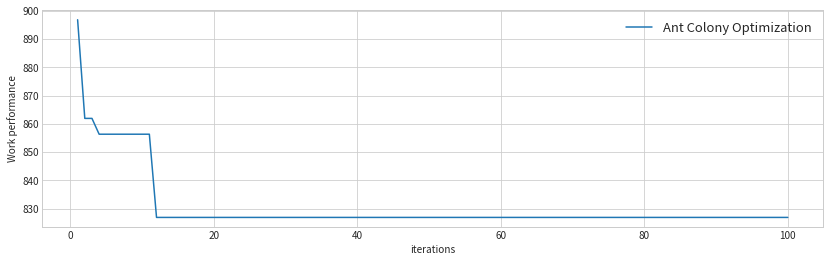

In [887]:
plt.figure(figsize=(14, 4))
plt.plot([i + 1 for i in range(len(total_ACO))], total_ACO, label='Ant Colony Optimization')

plt.xlabel("iterations")
plt.ylabel("Work performance")
plt.legend(fontsize=13)

## Particle Swarm Optimization


In [888]:
def PSO_main_program():
    n_iterations = 100
    pop_size = 100  # 鳥群數量
    solutions = []
    global_best_x, global_best_y = None, None  # 群體最佳解
    individual_best_x, individual_best_y = [], []  # 個體最佳解
    cognition_factor, social_factor = 1, 1
    total_PSO = []

    # initialize
    min_val = 1000
    for n in range(pop_size):
        one_solution = generate_x()
        solutions.append(one_solution)   

        # update invidual best solution
        individual_best_x.append(one_solution)
        individual_y = objective_f(one_solution)
        individual_best_y.append(individual_y)

        #record the smallest objective val
        if(individual_y < min_val):
            min_index = n
            min_val = individual_y

    # udpate so far the best solution
    global_best_x = solutions[min_index].copy()
    global_best_y = min_val

    def possible_position(best_array, solution_x, r):
        v = []
        chosen_day = np.random.choice(solution_x.shape[1], 5)
        for j in chosen_day:
            diff_index_i, diff_index_j = np.where(solution_x != best_array)
            index = [(i_0, j_0) for (i_0, j_0) in zip(diff_index_i, diff_index_j) if j_0 == j]
            if index:
                for k in range(1, len(index)):
                    if best_array[index[k]] == solution_x[index[0]]:
                        v.append( (index[0], index[k], r) )
                        break
        return v

    N = 0
    while N < n_iterations:
        # move to new positions
        for n, solution in enumerate(solutions):
            alpha = cognition_factor*np.random.sample()
            beta = social_factor*np.random.sample()
            v_individual = possible_position(individual_best_x[n], solution, alpha)
            v_global = possible_position(global_best_x, solution, beta)
            total_v = v_individual + v_global
            for (i, j, r) in total_v:
                if r < np.random.sample():
                    solution[i], solution[j] = solution[j], solution[i]
            if constraint(solution):
                solutions[n] = solution

        # update best solution
        for i, solution in enumerate(solutions):
            obj_val = objective_f(solution)
            # udpate indivisual solution
            if obj_val < individual_best_y[i] :
                individual_best_x[i] = solution
                individual_best_y[i] = obj_val
                if obj_val < global_best_y :
                    global_best_x = solution
                    global_best_y = obj_val
        total_PSO.append(global_best_y)
        N += 1
    return global_best_x, global_best_y, total_PSO 

In [889]:
best_x_PSO, best_y_PSO, total_PSO = PSO_main_program()

In [890]:
pd.DataFrame(best_x_PSO)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,d,d,d,l,h,h,d,n,d,d,d,d,d,n,d,d,d,d,d,l,d,d,d,h,d,l,d,d,d,l
1,d,d,d,d,d,d,l,h,d,d,n,d,d,d,l,d,l,d,l,d,l,d,l,d,n,d,d,d,l,d
2,d,l,d,d,d,d,d,d,d,d,d,l,h,h,d,d,d,d,d,d,d,n,d,d,d,d,d,d,d,d
3,n,d,l,d,d,l,d,h,n,d,d,d,d,d,d,d,d,l,d,d,n,d,d,d,l,n,n,d,d,d
4,d,d,d,d,d,n,d,d,d,d,d,d,n,d,d,d,n,h,h,n,d,d,d,d,l,d,d,d,d,d
5,d,d,d,d,n,d,n,d,d,n,l,d,d,d,d,l,l,n,n,d,d,d,n,h,h,d,d,d,d,n
6,d,d,n,d,n,d,d,d,d,l,l,n,n,d,d,n,d,d,n,l,n,d,h,l,h,l,d,l,n,d
7,d,d,d,d,d,n,d,d,d,l,h,l,d,d,d,d,d,d,d,n,d,d,d,l,d,n,d,d,l,d
8,l,d,l,d,l,d,d,l,l,n,d,d,d,l,n,d,d,d,d,d,d,h,h,n,d,d,d,d,d,d
9,d,d,d,d,d,d,d,d,d,d,d,d,l,h,d,d,n,d,d,h,d,l,d,d,d,d,n,d,n,d


In [891]:
best_y_PSO

758.3333333333334

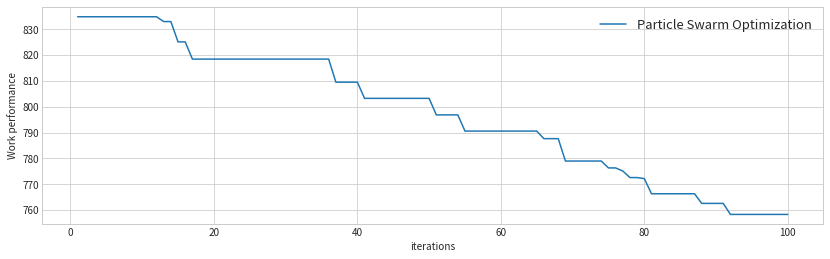

In [892]:
plt.figure(figsize=(14, 4))
plt.plot([i + 1 for i in range(len(total_PSO))], total_PSO, label='Particle Swarm Optimization')

plt.xlabel("iterations")
plt.ylabel("Work performance")
plt.legend(fontsize=13)

# 4. Plot
第2.3行為對齊顏色用

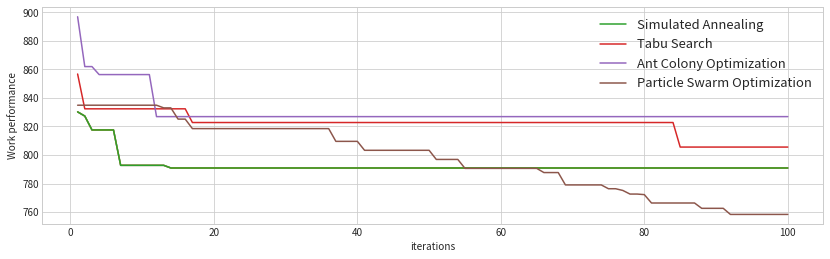

In [917]:
plt.figure(figsize=(14, 4))
plt.plot([i + 1 for i in range(len(total_SA))], total_SA)
plt.plot([i + 1 for i in range(len(total_SA))], total_SA)
plt.plot([i + 1 for i in range(len(total_SA))], total_SA, label='Simulated Annealing')
plt.plot([i + 1 for i in range(len(total_TS))], total_TS, label='Tabu Search')
plt.plot([i + 1 for i in range(len(total_ACO))], total_ACO, label='Ant Colony Optimization')
plt.plot([i + 1 for i in range(len(total_PSO))], total_PSO, label='Particle Swarm Optimization')

plt.xlabel("iterations")
plt.ylabel("Work performance")
plt.legend(fontsize=13)

# 5. Repeat all procedures for 10 times.

In [894]:
start = time.perf_counter()
HC_timeline, HC_y_ls = [0], []
for _ in range(10):
    _, y_HC, HC_ls = self_adaptive_ES(do_Random_Walk=False)
    time_consuming = time.perf_counter() - start
    HC_timeline.append(time_consuming)
    HC_y_ls.append(y_HC)

In [895]:
start = time.perf_counter()
RW_timeline, RW_y_ls = [0], []
for _ in range(10):
    _, y_RW, RW_ls = self_adaptive_ES(do_Random_Walk=True)
    time_consuming = time.perf_counter() - start
    RW_timeline.append(time_consuming)
    RW_y_ls.append(y_RW)

In [896]:
start = time.perf_counter()
SA_timeline, SA_y_ls = [0], []
for _ in range(10):
    _, y_SA, SA_ls = SA_main_program_particle()
    time_consuming = time.perf_counter() - start
    SA_timeline.append(time_consuming)
    SA_y_ls.append(y_SA)

In [897]:
start = time.perf_counter()
TS_timeline, TS_y_ls = [0], []
for _ in range(10):
    _, y_TS, TS_ls = TS_main_program_particle()
    time_consuming = time.perf_counter() - start
    TS_timeline.append(time_consuming)
    TS_y_ls.append(y_TS)

In [898]:
start = time.perf_counter()
ACO_timeline, ACO_y_ls = [0], []
for _ in range(10):
    _, y_ACO, ACO_ls = ACO_main_program()
    time_consuming = time.perf_counter() - start
    ACO_timeline.append(time_consuming)
    ACO_y_ls.append(y_ACO)

In [899]:
start = time.perf_counter()
PSO_timeline, PSO_y_ls = [0], []
for _ in range(10):
    _, y_PSO, PSO_ls = PSO_main_program()
    time_consuming = time.perf_counter() - start
    PSO_timeline.append(time_consuming)
    PSO_y_ls.append(y_PSO)

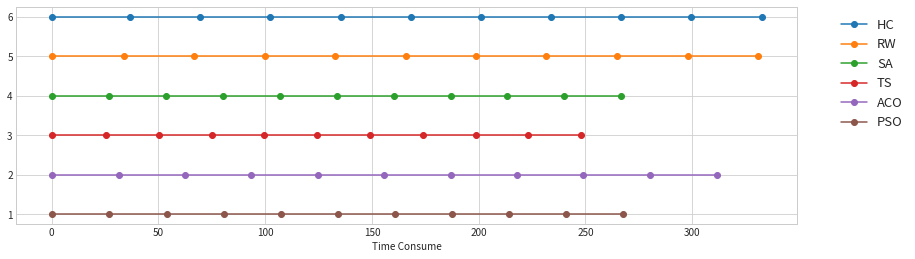

In [921]:
## 純耗時比較圖
plt.figure(figsize=(14, 4))
plt.plot(HC_timeline, [6 for i in range(len(HC_timeline))], 'o-', label='HC')
plt.plot(RW_timeline, [5 for i in range(len(RW_timeline))], 'o-', label='RW')
plt.plot(SA_timeline, [4 for i in range(len(SA_timeline))], 'o-', label='SA')
plt.plot(TS_timeline, [3 for i in range(len(TS_timeline))], 'o-', label='TS')
plt.plot(ACO_timeline, [2 for i in range(len(ACO_timeline))], 'o-', label='ACO')
plt.plot(PSO_timeline, [1 for i in range(len(PSO_timeline))], 'o-', label='PSO')

plt.xlabel("Time Consume")
plt.legend(fontsize=13, bbox_to_anchor=(1.15, 1))

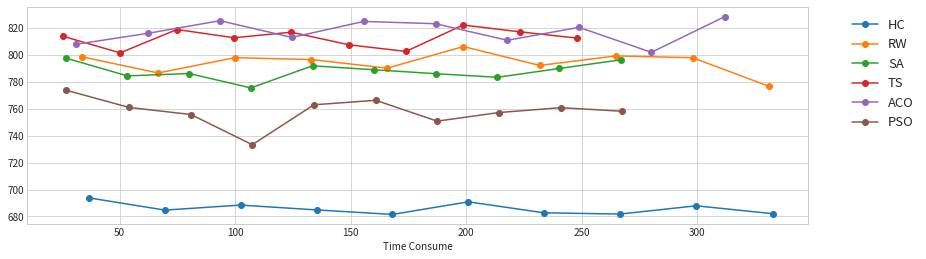

In [925]:
## 耗時 v.s. best_y 比較圖
plt.figure(figsize=(14, 4))
plt.plot(HC_timeline[1:], HC_y_ls, 'o-', label='HC')
plt.plot(RW_timeline[1:], RW_y_ls, 'o-', label='RW')
plt.plot(SA_timeline[1:], SA_y_ls, 'o-', label='SA')
plt.plot(TS_timeline[1:], TS_y_ls, 'o-', label='TS')
plt.plot(ACO_timeline[1:], ACO_y_ls, 'o-', label='ACO')
plt.plot(PSO_timeline[1:], PSO_y_ls, 'o-', label='PSO')

plt.xlabel("Time Consume")
plt.legend(fontsize=13, bbox_to_anchor=(1.15, 1))

In [922]:
pd.DataFrame({
    'HC': [np.mean([HC_timeline[t+1] - HC_timeline[t] for t in range(9)]), np.mean(HC_y_ls)],
    'RW': [np.mean([RW_timeline[t+1] - RW_timeline[t] for t in range(9)]), np.mean(RW_y_ls)],
    'SA': [np.mean([SA_timeline[t+1] - SA_timeline[t] for t in range(9)]), np.mean(SA_y_ls)],
    'TS': [np.mean([TS_timeline[t+1] - TS_timeline[t] for t in range(9)]), np.mean(TS_y_ls)],
    'ACO':[np.mean([ACO_timeline[t+1] - ACO_timeline[t] for t in range(9)]), np.mean(ACO_y_ls)],
    'PSO':[np.mean([PSO_timeline[t+1] - PSO_timeline[t] for t in range(9)]), np.mean(PSO_y_ls)],
})

,HC,RW,SA,TS,ACO,PSO
0,33.279332,33.108413,26.683034,24.817085,31.127209,26.772899
1,685.880000,794.093333,787.920000,812.453333,817.066667,757.920000
